In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc

import scipy.interpolate

In [2]:

def simuler(mv_test, # eV
            kvec,k_special=1,factor = 2.68,T_ini = 1000,H0 = 67.040):
    
    Res = np.zeros(len(kvec))
    Res1 = np.zeros(len(kvec))
    Res2 = np.zeros(len(kvec))
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    h = 0.6704
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                }
    H0 /= (3*1e5) # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    #print(bg.keys())
    z = bg["z"]
    a = 1/(z+1)
    aend = a[-1]
    a0 = a[0]
    mv = mv_test * 1e-6
    # cs front faktoren
    


    # udregner Hubbleparameteren

    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    # udregnger tau 

    def tau_cal(a,y):
        # Vores "tids"-værdi i denne differentialligning er a
        tau = y[0]
        d_tau = 1 / (a ** 2 * H(a))
        return np.array(d_tau)

    # temperatur

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a,mv,factor):
        return factor * Tv(a) / mv

    # udregn a
    def a_solve(tau,y):
        a = y[0]
        a_dt = a * a * H(a)
        return [a_dt]

    tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


    sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
    tau = sol_tau.y[0]

    sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
    a_tau = sol_a.t
    a = sol_a.y[0]

    a_interp = scipy.interpolate.interp1d(a_tau,a)

    # simulerings funktionerne

    def func_det_hele(τ,y,k,mv,factor):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        d_theta      =  -  H(a) * a * theta    - (3/2) * H0*H0 * Omega_M * delta / a
        delta_nu = y[2]
        theta_nu = y[3]
        d_delta_nu   = - theta_nu
        d_theta_nu   =  -  H(a) * a * theta_nu - (3/2) * H0*H0 * Omega_M * delta / a  + k**2 * cs(a,mv,factor)**2 * delta_nu
        return [d_delta,d_theta,d_delta_nu,d_theta_nu]

    def func_del1(τ,y):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        #nabla2phi = 
        d_theta   =  - (3/2) * H0*H0 * Omega_M * delta / a-  H(a) * theta * a
        return [d_delta,d_theta]

    
    t_gem = T_ini
    for k_ind,k in enumerate(kvec):
        T_ini = t_gem
        
        delta_class = pts[k_ind]["delta_cdm"]
        theta_class = pts[k_ind]["theta_cdm"]
        tau_class = pts[k_ind]["tau [Mpc]"]
        delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
        theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
        a_class = pts[k_ind]["a"]
        if T_ini < tau_class[0]:
            print("Din T_ini er for lav.")
            print("T_ini sættes til lavest tau i class = %s ved k = %s" % (tau_class[0],k))
            T_ini = tau_class[0]
            #raise ValueError("T_ini=%s<tau[0]=%s" %(T_ini,tau_class[0]))
            
        delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
        theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)
        delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
        theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)
        
        
        τ_span = [T_ini,tau[-1]]

        y0 = [delta_init,theta_init,delta_neutrino_init,theta_neutrino_init]

        sol_en = sc.solve_ivp(func_det_hele, t_span = τ_span, y0 = y0,args=(k,mv,factor))

        τ_cdm_en = sol_en.t
        delta_cdm_en = sol_en.y[0]
        delta_nu_en = sol_en.y[2]

        Res[k_ind] = delta_nu_en[-1]
        
        # T-span1

        y01 = [delta_init,theta_init]

        sol_del1 = sc.solve_ivp(func_del1, t_span = τ_span, y0 = y01)

        τ_del1 = sol_del1.t

        delta_del1 = sol_del1.y[0]

        delta_cdm_interp = scipy.interpolate.interp1d(τ_del1,delta_del1)


        def func_del2(τ,y,k,mv,factor):
            delta = y[0]
            theta = y[1]    
            a = a_interp(τ)
            d_delta   = - theta
            delta_cdm = delta_cdm_interp(τ)
            d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta
            return [d_delta,d_theta]

        y01_neutrino = [delta_neutrino_init,theta_neutrino_init]
        
        sol_neu1 = sc.solve_ivp(func_del2, t_span = τ_span, y0 = y01_neutrino,args=(k,mv,factor))
        
        Res1[k_ind] = sol_neu1.y[0][-1]
        Res2[k_ind] = delta_del1[-1]
        
        if k == k_special:
            plt.figure(3214)
            plt.loglog(tau_class,-delta_class,label="class cdm")
            plt.loglog(sol_neu1.t,-sol_neu1.y[0],label="alene neutrino")
            plt.loglog(τ_del1,-delta_del1,label="alene cdm")
            plt.loglog(τ_cdm_en,-delta_cdm_en,"-",label="cdm samlet")
            plt.loglog(τ_cdm_en,-delta_nu_en,"-.",label="neu samlet")
            plt.loglog(tau_class,-delta_neutrino_class,label="class neu")
            plt.xlabel("tau")
            plt.legend()
            plt.title(r"$m_{\nu}=$%s eV k=%s cs-factor = %s" % (mv_test,k_special,factor))
    
    
    tranf = cosmo.get_transfer(z=0)
    #print(tranf.keys())
    prim = cosmo.get_primordial()
    #print(prim.keys())

    k = tranf['k (h/Mpc)'] * h
    kvec = np.array(kvec)
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")

    # løs alt sammentidig

    # plot det hele
    plt.figure(1)

    plt.loglog(k, 2*np.pi**2 * tranf["d_ncdm[0]"] ** 2* k ** (-3) * prim_interp(k) * h ** 3,label="neutrino")
    plt.loglog(k, 2*np.pi**2 * tranf["d_m"] ** 2 * k ** (-3) *  prim_interp(k) * h ** 3,label="matter")
    plt.loglog(kvec,2*np.pi**2 * Res2** 2 * kvec**(-3) * prim_interp(kvec) * h ** 3,"-",label="min hver for sig matter")
    plt.loglog(kvec,2*np.pi**2 * Res ** 2 * kvec**(-3) * prim_interp(kvec) * h ** 3,label="min samlet neu")
    plt.loglog(kvec,2*np.pi**2 * Res1** 2 * kvec**(-3) * prim_interp(kvec) * h ** 3,"-.",label="min hver for sig neu")
    
    plt.xlabel("k")
    plt.title("mv = %s eV T_ini = %s cs-factor = %s "%(mv_test,T_ini,factor))
    plt.legend()
    plt.xlim([kvec[0],kvec[-1]])
    
    
    return None



[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 10.0]


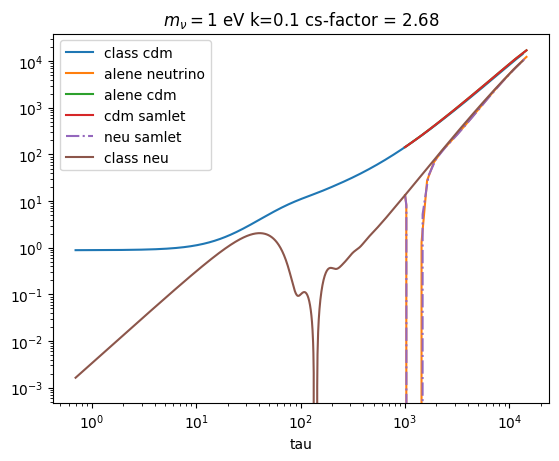

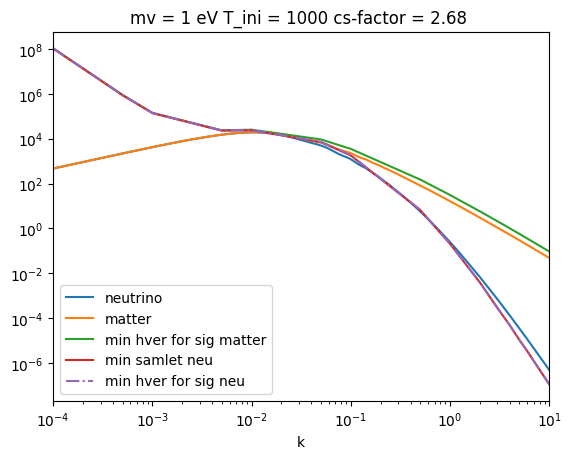

In [3]:
mv = 1

kvec = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,1e1]
print(kvec)
a = simuler(mv,kvec=kvec,k_special=0.1,T_ini=1000)
a

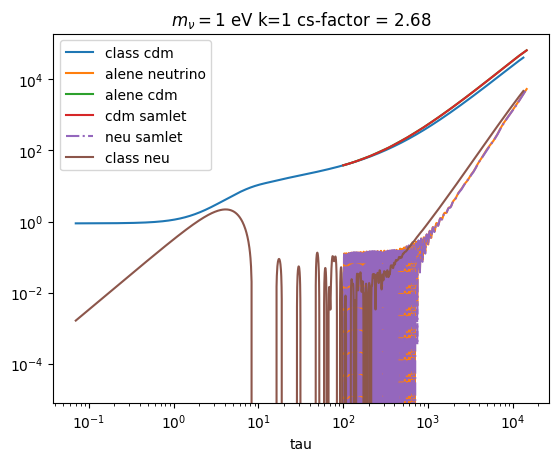

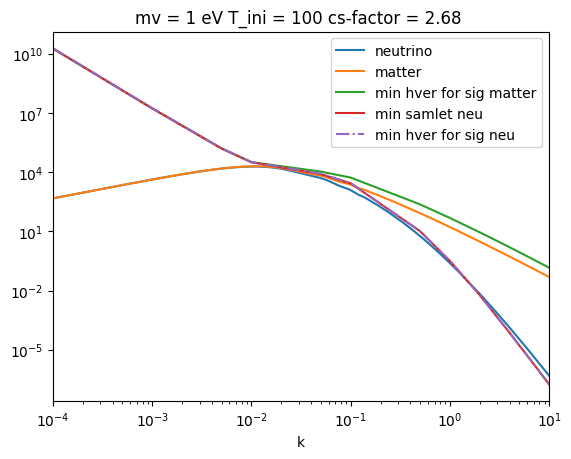

In [4]:
b = simuler(mv,kvec=kvec,T_ini=100)
b

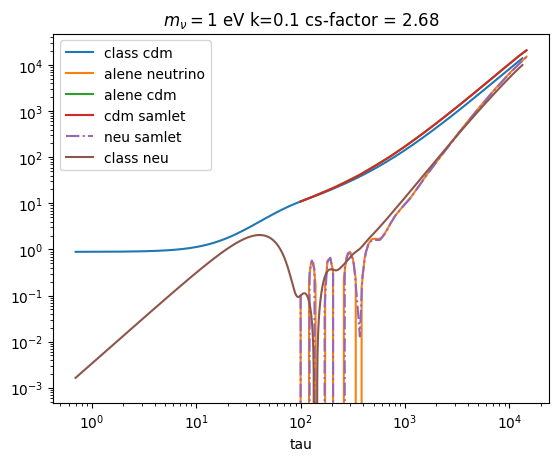

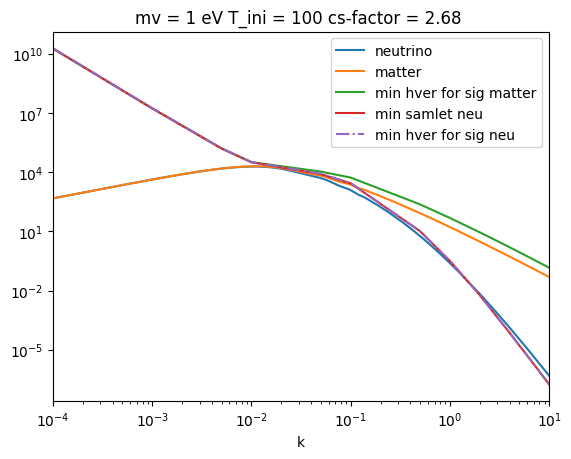

In [5]:
c = simuler(mv,kvec=kvec,T_ini=100,k_special=1e-1)

c


Din T_ini er for lav.
T_ini sættes til lavest tau i class = 10.415792524773943 ved k = 0.0001
Din T_ini er for lav.
T_ini sættes til lavest tau i class = 10.410993084536072 ved k = 0.0005
Din T_ini er for lav.
T_ini sættes til lavest tau i class = 10.410843102028567 ved k = 0.001
Din T_ini er for lav.
T_ini sættes til lavest tau i class = 10.410795107626466 ved k = 0.005


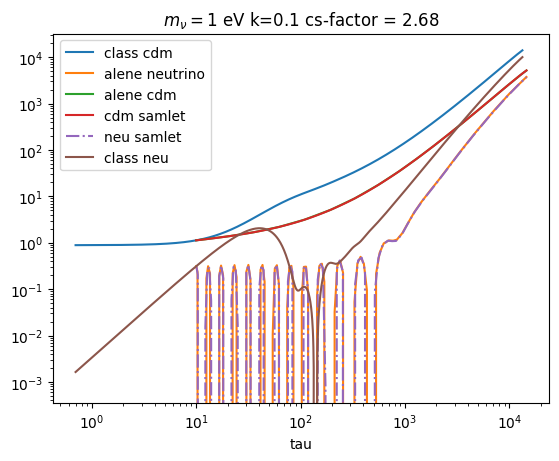

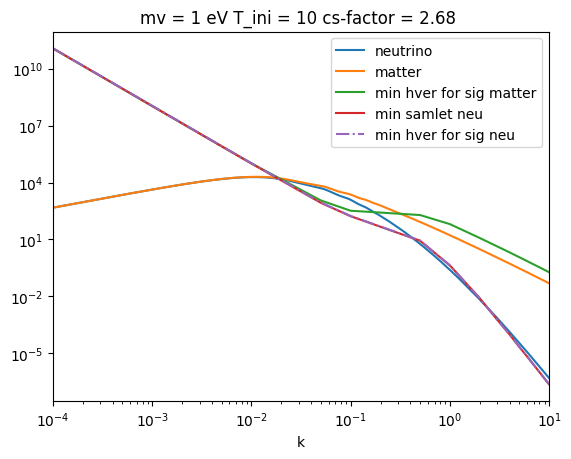

In [6]:
g = simuler(mv,kvec=kvec,T_ini=10,k_special=1e-1)

g


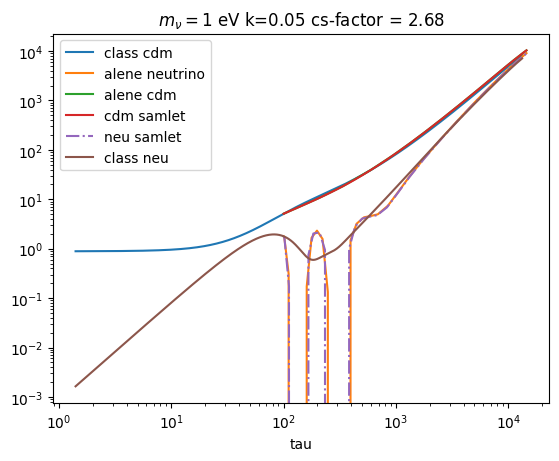

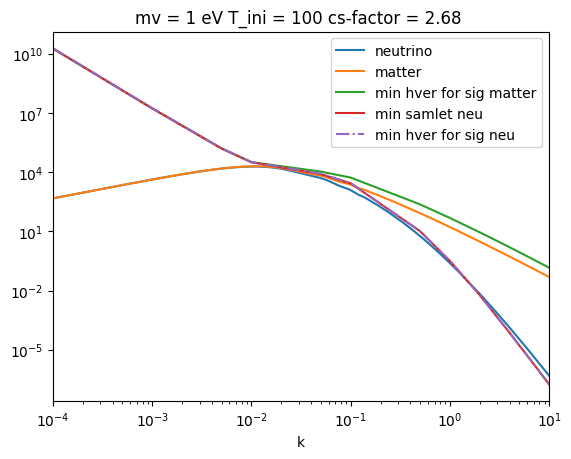

In [7]:
d = simuler(mv,kvec=kvec,T_ini=100,k_special=5e-2)
d

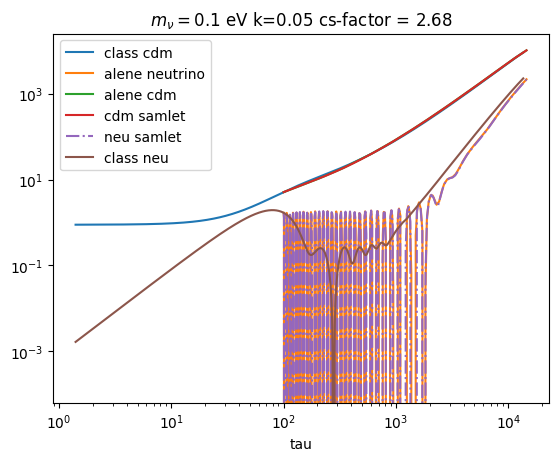

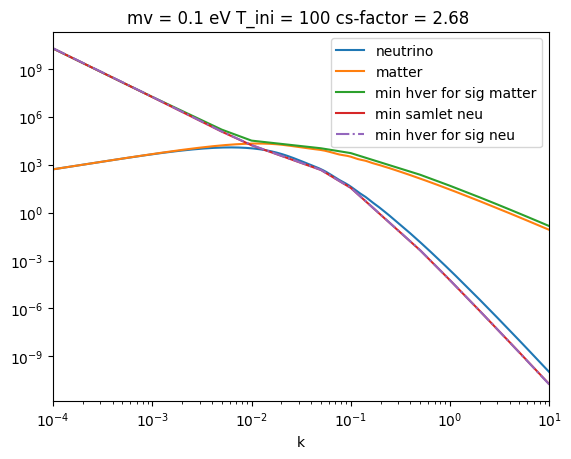

In [8]:
mv = 1e-1
e = simuler(mv,kvec=kvec,T_ini=100,k_special=5e-2)
e

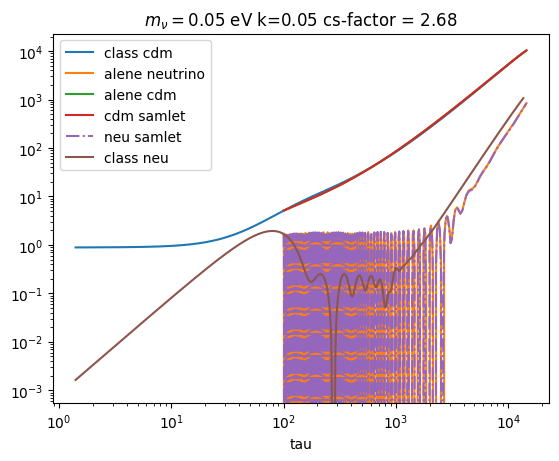

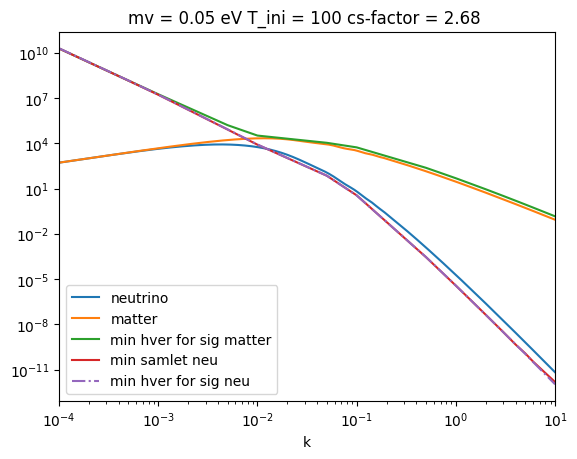

In [9]:
mv = 5e-2
f = simuler(mv,kvec=kvec,T_ini=100,k_special=5e-2)
f

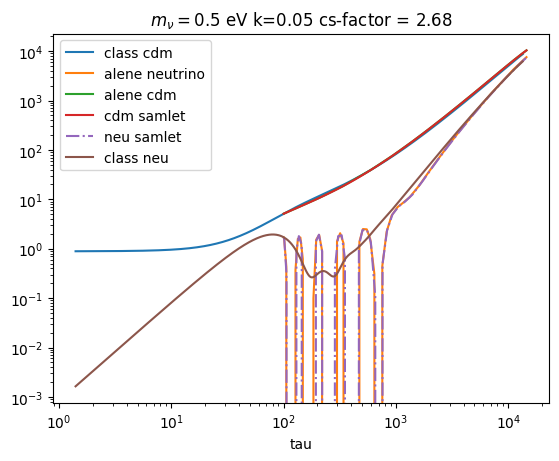

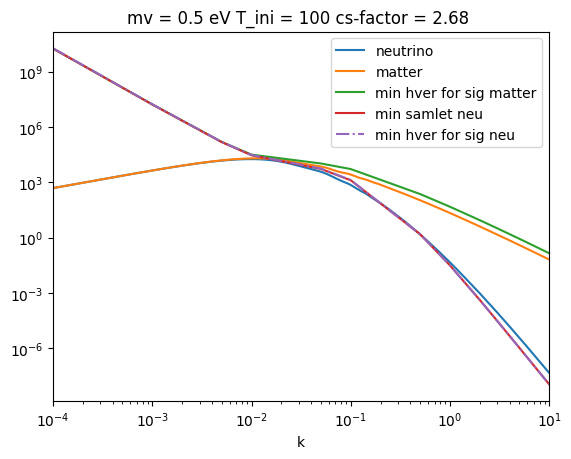

In [10]:
mv = 5e-1
g = simuler(mv,kvec=kvec,T_ini=100,k_special=5e-2)
g

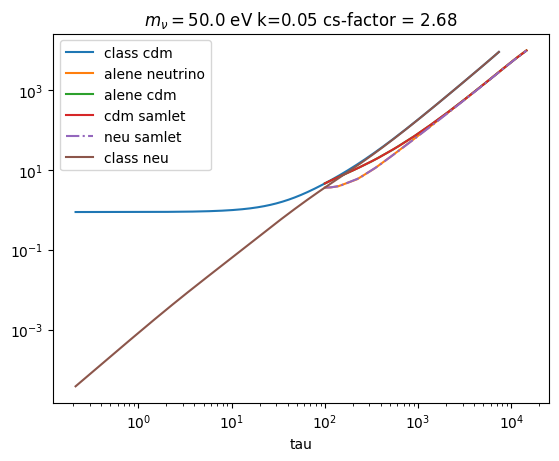

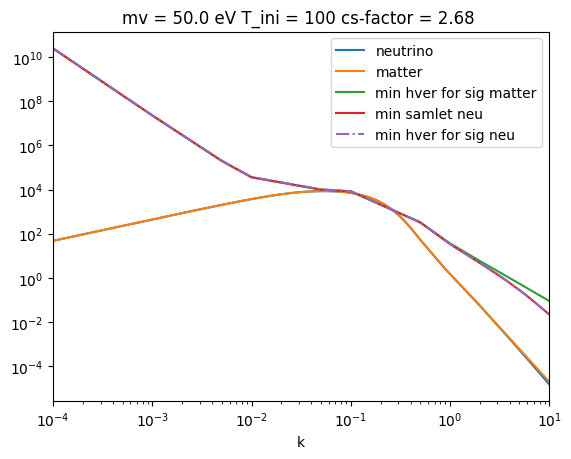

In [11]:
mv = 5e1
g = simuler(mv,kvec=kvec,T_ini=100,k_special=5e-2)
g

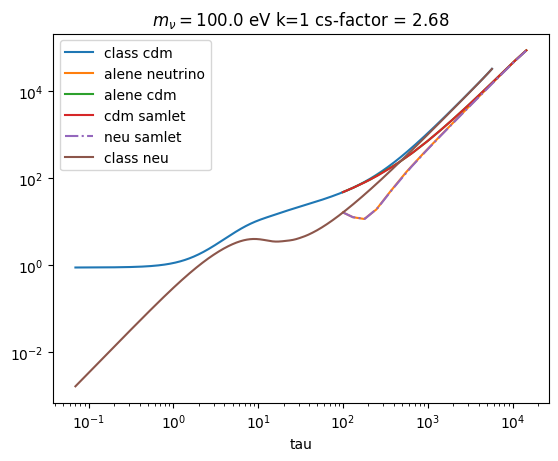

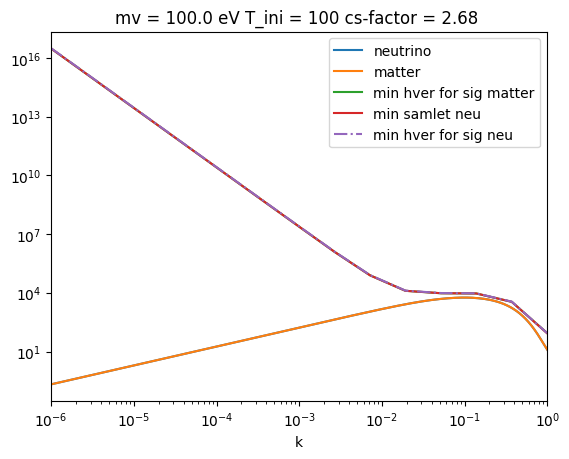

In [12]:
mv_test = 1e2
kvec = list(np.logspace(-6,0,15))
simuler(mv_test, # eV
        kvec,factor = 2.68,T_ini = 100)

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 10.0]


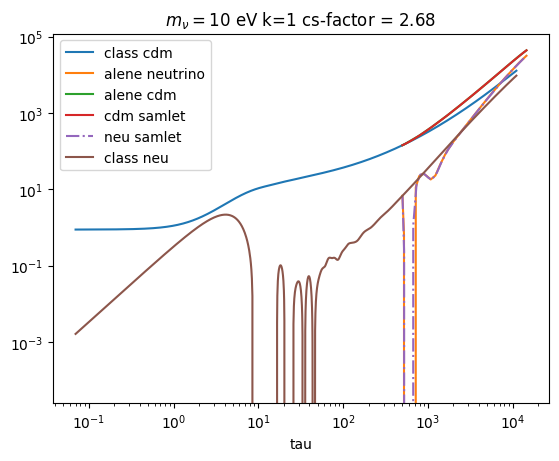

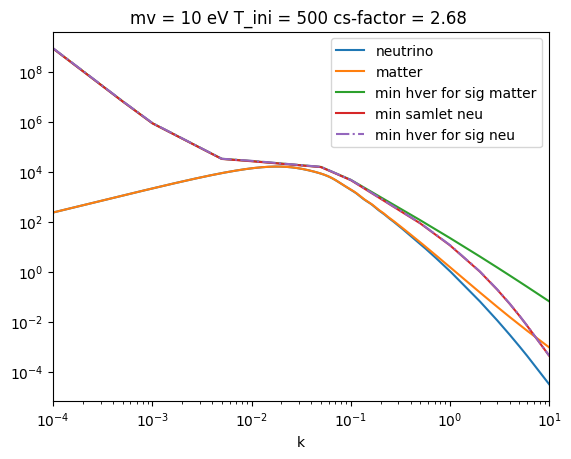

In [13]:
mv = 10

kvec = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,1e1]
print(kvec)
a = simuler(mv,kvec=kvec,T_ini=500)
a

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 10.0]


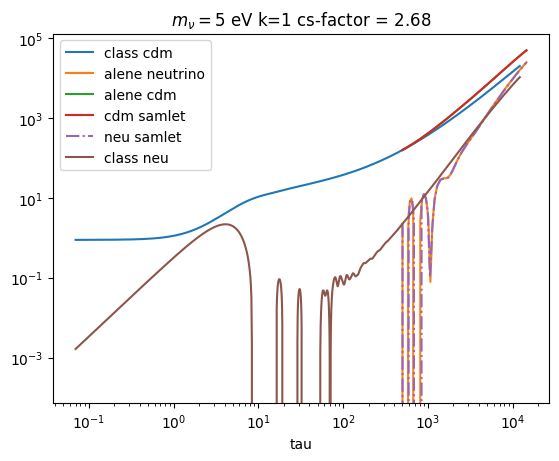

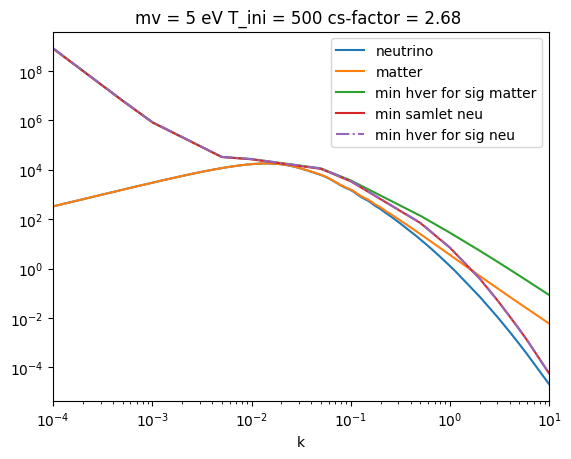

In [14]:
mv = 5

kvec = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,1e1]
print(kvec)
a = simuler(mv,kvec=kvec,T_ini=500)
a

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 10.0]


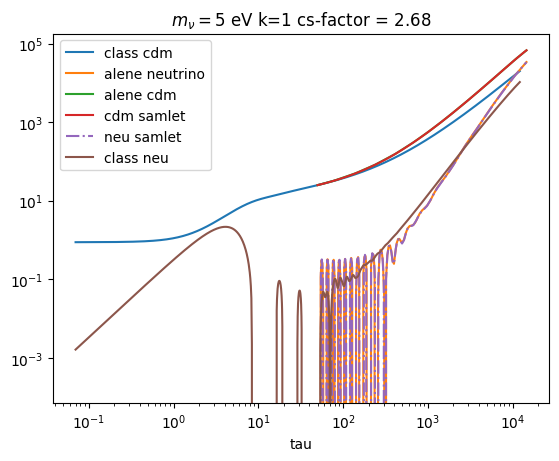

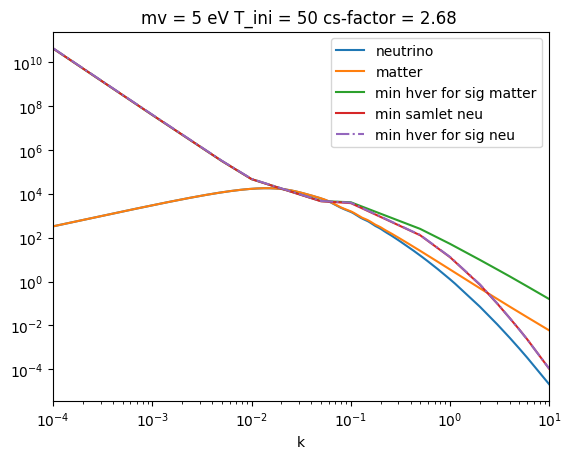

In [15]:
mv = 5

kvec = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,1e1]
print(kvec)
a = simuler(mv,kvec=kvec,T_ini=50)
a

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 10.0]


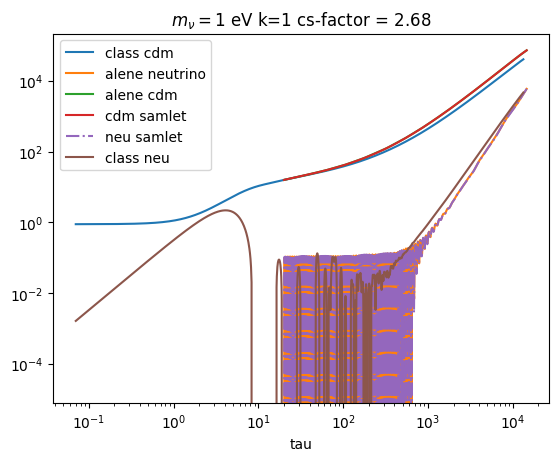

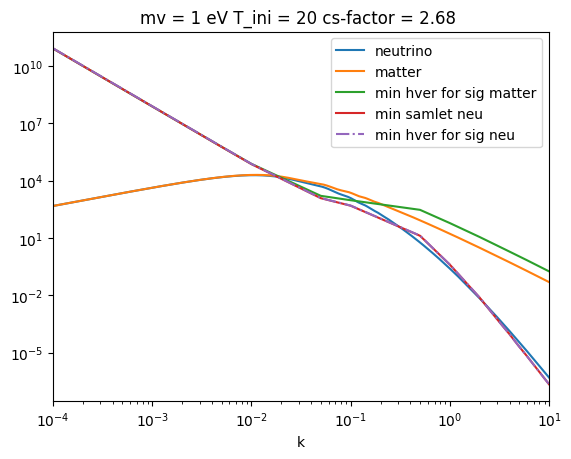

In [16]:
mv = 1

kvec = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,1e1]
print(kvec)
a = simuler(mv,kvec=kvec,T_ini=20)
a